# test model on test data 
Test the model on the test data and save the results.

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import os 
os.environ['MPLCONFIGDIR'] = '/myhome'
from utils.plots import plot_label_distribution_datasets
from utils.helpers_config import set_up_config, save_config, print_config
from utils.test.helpers_testing import get_test_stats_from_model, load_test_dataset, save_test_stats
from utils.plots_test import plots_all_figs_at_test, plot_confusion_matrix_like_elects
import matplotlib.pyplot as plt
from utils.test.load_model import get_all_runs, get_loaded_model_and_criterion, get_model_and_model_path
from utils.helpers_mu import get_mus_from_config
from utils.results_analysis.extract_video import download_images, add_files_to_images, save_video
import argparse

In [3]:
run_name = "ELECTS-LSTM"
sequencelength_test = 150
plot_label_distribution = False
print("Run name: ", run_name)


Run name:  ELECTS-LSTM


In [4]:
print(f"Test the model from run '{run_name}' on the test dataset")
local_dataroot = os.path.join(os.environ.get("HOME", os.environ.get("USERPROFILE")),"elects_data")
print("Local dataroot: ", local_dataroot)

# ## Download the model from wandb 
entity, project = "aurenore", "MasterThesis"
runs_df, runs = get_all_runs(entity, project)

# get the run with name:
run_idx = runs_df[runs_df.name == run_name].index[0]
run = runs[run_idx]
run_config = argparse.Namespace(**run.config)
model_artifact, model_path = get_model_and_model_path(run)

# get and save the config
config_path = save_config(model_path, run)
print_config(run)
args  = set_up_config(run_config)
args.dataroot = local_dataroot

# ----------------------------- LOAD DATASET -----------------------------
# Set the sequence length to 150 like in the original paper.
if sequencelength_test is None: 
    sequencelength_test = run_config.sequencelength
else: 
    args.sequencelength = sequencelength_test
test_ds, nclasses, class_names, input_dim = load_test_dataset(args)

# ----------------------------- VISUALIZATION: label distribution -----------------------------
if plot_label_distribution:
    datasets = [test_ds]
    sets_labels = ["Test"]
    fig, ax = plt.subplots(figsize=(15, 7))
    fig, ax = plot_label_distribution_datasets(datasets, sets_labels, fig, ax, title='Label distribution', labels_names=class_names)

# ## Load the models and the criterions
mus = get_mus_from_config(args)
model, criterion = get_loaded_model_and_criterion(run, nclasses, input_dim, mus=mus)

# ## Test the model on the test dataset
test_stats, stats = get_test_stats_from_model(model, test_ds, criterion, args)
print("test_stats:\n", test_stats)
test_stats_path = save_test_stats(model_path, test_stats)


Test the model from run 'ELECTS-LSTM' on the test dataset
Local dataroot:  C:\Users\anyam\elects_data


wandb:   1 of 1 files downloaded.  


config file saved at:  c:\Users\anyam\Desktop\Master_thesis\Code\elects\artifacts\run-z6s1065x-model.pth-v8\config.json
-------------------------------------------------- Configuration: --------------------------------------------------
alpha: 0.5
device: cuda
epochs: 100
resume: False
dataset: breizhcrops
epsilon: 10
dataroot: /mydata/studentanya/anya/elects_data
patience: 30
snapshot: /mydata/studentanya/anya/elects_snapshots/breizhcrops/elects-breizhcrops-training/model.pth
batchsize: 256
criterion: EarlyRewardLoss
optimizer: AdamW
architecture: EarlyRNN
weight_decay: 0
learning_rate: 0.001
sequencelength: 70
------------------------------------------------------------------------------------------------------------------------------------------------------
1555075632 1555075632


loading data into RAM: 100%|██████████| 122614/122614 [00:45<00:00, 2692.63it/s]


class names: ['barley' 'wheat' 'rapeseed' 'corn' 'sunflower' 'orchards' 'nuts'
 'permanent meadows' 'temporary meadows']


wandb:   1 of 1 files downloaded.  


model is loading from:  c:\Users\anyam\Desktop\Master_thesis\Code\elects\artifacts\run-z6s1065x-model.pth-v8
The model has 67,108 trainable parameters.
test_stats:
 {'test_loss': 0.9596296, 'accuracy': 0.8005203320991078, 'precision': 0.6778511958599838, 'recall': 0.5694615641419527, 'fscore': 0.568894222026064, 'kappa': 0.7401214124690126, 'elects_earliness': 0.8518021798752302, 'classification_loss': 5.9757733, 'earliness_reward': 4.0565147, 'harmonic_mean': 0.8253654585891808, 'std_score': 7.025425669592215}
test_stats saved at  c:\Users\anyam\Desktop\Master_thesis\Code\elects\artifacts\run-z6s1065x-model.pth-v8\test_stats.json


# --------------------- VISUALIZATION: stopping times and timestamps left-----------------------------


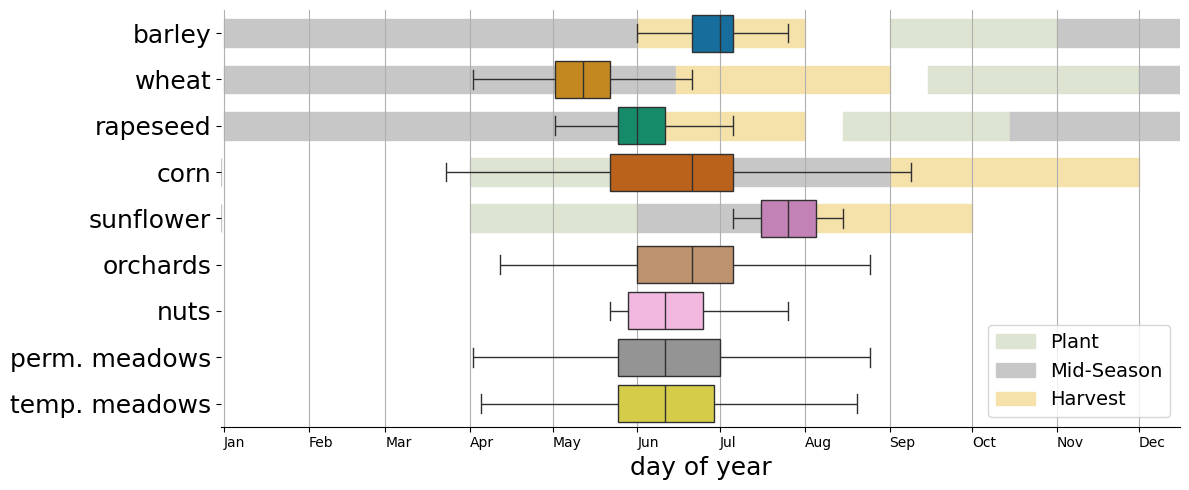

In [18]:
from utils.plots import boxplot_stopping_times, plot_timestamps_left_per_class, create_figure_and_axes
from utils.doy import get_doys_dict_test, get_doy_stop

fig_boxplot, ax_boxplot = plt.subplots(figsize=(12, 5))
if args.daily_timestamps:
    doys_stop = stats["t_stop"].squeeze()
else: 
    doys_dict_test = get_doys_dict_test(dataroot=os.path.join(args.dataroot,args.dataset))
    doys_stop = get_doy_stop(stats, doys_dict_test, approximated=False)
fig_boxplot, ax_boxplot = boxplot_stopping_times(doys_stop, stats, fig_boxplot, ax_boxplot, class_names, show_crop_calendar=True)
# fig_filename = os.path.join(model_path, "boxplot_stopping_times.png")
# fig_boxplot.savefig(fig_filename)
# print("fig saved at ", fig_filename)


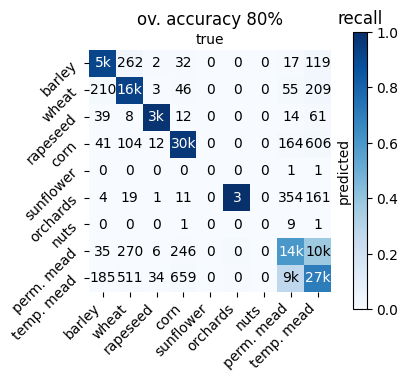

In [19]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
fig, ax = plot_confusion_matrix_like_elects(fig, ax, stats)